In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

%matplotlib inline

# Lyft Bay Wheels - EDA with SQL & Python
#### By Jonathan Whiteley
---

As the Bay Area's leading bike share company, Lyft Bay Wheel provides locals and vistors alike a fast and efficient means of getting around the San Franscisco, San Jose, Mountain View, Redwood City, and Palo Alto. Lyft Bay Wheels has experienced widescale adoption in its first three years of operation since its launch in August 2013. 

Current bikeshare offers:
- Single Trip
- Traditional Membership - Monthly or Annual
- Reduced Cost Membership 
    - Bike Share for All Membership
    - Corporate Membership
    - University Membership

## Key Questions
Lyft Bay Wheels has approached our team to help determine scalable solutions to drive increased ridership. Our team has analyzed the historical trips data provided in order to address the following key questions:
1. **What are the 5 most popular commuter trips?**
2. **What offers should Lyft Bay Wheels consider implementing to improve ridership?**

## Initial EDA



- The dataset analyzed included **983648 trips** across a three year period from **8-29-2013 to 8-31-2016** with **700** unique bikes.
 
 
- 983648

```sql
SELECT COUNT(*) as trip_count
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
```

- min_time : 2013-08-29 09:08:00 UTC
- max_time : 2016-08-31 23:48:00 UTC


```sql
SELECT min(start_date) as min_time,
max(end_date) as max_time
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
```

- 700
  
```sql
SELECT count(distinct bike_number)
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
```


## Assumptions
- **Time Zone:** The start_date and end_date columns are returned in UTC time zone. However from the documentation within the Table Schema in BigQuery indicates PST. By plotting the hour of the day for the entire trips table, it looks to confirm the documentation is correct with the ride times consistent with waking hours for San Francisco in PST
- **Zip Code:** The documentation indicates that the zip_code field is the zip code of subscriber, however customers can choose to manually enter zip at kiosk so they caution this might be unreliable. For this analysis, we confirmed this statement and avoided using this field after confirming high % of non-subscriber zip_codes were either 'nil' or blank. 

In [25]:
%%bigquery hour_df

SELECT EXTRACT (HOUR FROM start_date) as hour_n, 
COUNT(*) as trip_count
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY hour_n
ORDER BY hour_n

Downloading: 100%|██████████| 24/24 [00:01<00:00, 14.85rows/s]


In [26]:
hour_df = hour_df.set_index('hour_n')

Text(0.5, 0, 'Hour (military time)')

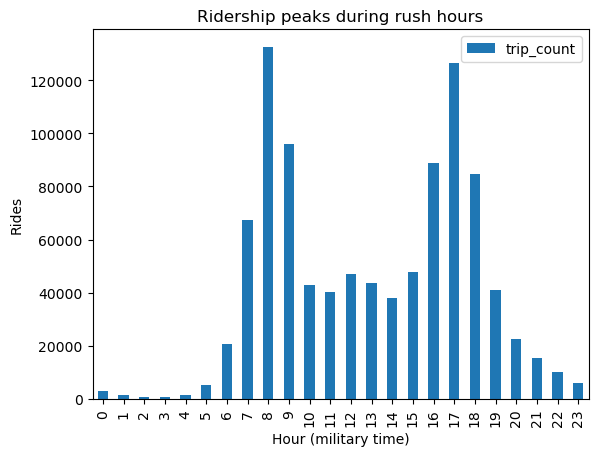

In [27]:
ax = hour_df.plot.bar()
ax.set_title("Ridership peaks during rush hours")
ax.set_ylabel("Rides")
ax.set_xlabel("Hour (military time)")

In [28]:
%%bigquery zip_df

SELECT zip_code,
COUNT(*) as zip_count
FROM `my-project-85244-313100.san_francisco_citi_bike_jw.bikeshare_commuter_trips`
WHERE subscriber_type = 'Customer'
GROUP BY zip_code
ORDER BY zip_count DESC;

Downloading: 100%|██████████| 3802/3802 [00:01<00:00, 2351.94rows/s]


In [29]:
zip_df['pct_trips'] = round((zip_df['zip_count'] / zip_df['zip_count'].sum()) * 100, 0)
zip_df.head()

zip_code  zip_count  pct_trips
0      nil       3133       11.0
1                1281        5.0
2    94107        602        2.0
3    94105        346        1.0
4    94102        344        1.0

## Sub-questions

### Who is riding?
Over the entire period, we see around 14% of riders are non-subcribers. This is the group we want to target with promotions and offers to push them towards becoming subscribers.

We also see in the below chart that each year from 2013-2016 shows a consistent proportion of customers to subcribers.


In [30]:
%%bigquery subs_df

SELECT trips.subscriber_type, count(*) as type_tripcount
FROM `bigquery-public-data.san_francisco.bikeshare_trips` as trips
GROUP BY trips.subscriber_type
ORDER BY trips.subscriber_type DESC

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.45rows/s]


In [31]:
subs_df['pct_trips'] = round((subs_df['type_tripcount'] / subs_df['type_tripcount'].sum()) * 100, 0)
subs_df

subscriber_type  type_tripcount  pct_trips
0      Subscriber          846839       86.0
1        Customer          136809       14.0

In [32]:
%%bigquery subs_year_df

SELECT trips.subscriber_type, 
EXTRACT (YEAR FROM start_date) as year_n, 
COUNT(*) as tripcount
FROM `bigquery-public-data.san_francisco.bikeshare_trips` as trips
GROUP BY year_n, trips.subscriber_type
ORDER BY year_n, trips.subscriber_type DESC

Downloading: 100%|██████████| 8/8 [00:01<00:00,  6.25rows/s]


In [33]:
subs_year_df = subs_year_df.pivot(index='year_n',columns='subscriber_type', values='tripcount')

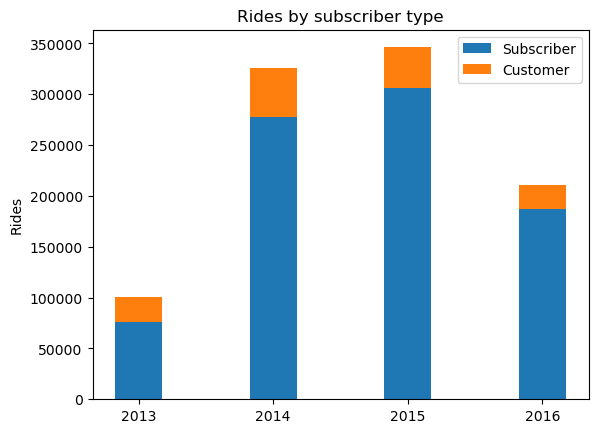

In [34]:
width = 0.35       
fig, ax = plt.subplots()

ax.bar(subs_year_df.index, subs_year_df.Subscriber, width, label='Subscriber')
ax.bar(subs_year_df.index, subs_year_df.Customer, width, bottom=subs_year_df.Subscriber,
       label='Customer')

ax.set_ylabel('Rides')
ax.set_title('Rides by subscriber type')
ax.set_xticks([2013, 2014, 2015, 2016])
ax.legend()

### When are they riding? 
Weekdays appear to be far busier than weekdays, indicating the importance of commuter ridership. This focus on commuting was confirmed by looking at the start time by hour in our first plot under the Time Zone assumption.

In [35]:
%%bigquery days_df

SELECT FORMAT_DATETIME('%A', start_date) as day_of_week, 
COUNT(*) as num_trips
FROM `bigquery-public-data.san_francisco.bikeshare_trips` as trips
GROUP BY day_of_week
ORDER BY  num_trips DESC

Downloading: 100%|██████████| 7/7 [00:01<00:00,  4.42rows/s]


In [36]:
days_df

day_of_week  num_trips
0     Tuesday     184405
1   Wednesday     180767
2    Thursday     176908
3      Monday     169937
4      Friday     159977
5    Saturday      60279
6      Sunday      51375

### What is a commuter trip?
To answer the first question of where are the most popular commuter trips, we first had to address the what defines a commuter trip. I defined a 'commuter trip' on the following criteria:
- Occurred during rush hour (7a-9a, 4p-6p) on M-F
- Was not a round trip (start and end station not the same) 

SQL query used to produce view, *my-project-85244-313100.san_francisco_citi_bike_jw.bikeshare_commuter_trips*:
  
```sql
SELECT EXTRACT (DAYOFWEEK FROM start_date) as day_of_week_n,
EXTRACT (HOUR FROM start_date) as hour_n,*
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE start_station_id != end_station_id
AND EXTRACT (DAYOFWEEK FROM start_date) BETWEEN 1 AND 5
AND (EXTRACT (HOUR FROM start_date) BETWEEN 7 AND 9 
OR EXTRACT (HOUR FROM start_date) BETWEEN 16 AND 18)
```

We can now aggregate by start station to determine where the top 5 most popular commuter trips

## Findings

### Most Popular Commuter Trips

In [54]:
%%bigquery trips_df

SELECT trips.start_station_name,
trips.end_station_name, 
count(*) as trip_count
FROM `my-project-85244-313100.san_francisco_citi_bike_jw.bikeshare_commuter_trips` as trips
GROUP BY start_station_id,
end_station_id, trips.start_station_name, trips.end_station_name
ORDER BY trip_count DESC
LIMIT 5;

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.11rows/s]


In [55]:
trips_df

start_station_name  \
0     Harry Bridges Plaza (Ferry Building)   
1                          2nd at Townsend   
2  San Francisco Caltrain 2 (330 Townsend)   
3                   Embarcadero at Sansome   
4                    Embarcadero at Folsom   

                           end_station_name  trip_count  
0                           2nd at Townsend        4379  
1      Harry Bridges Plaza (Ferry Building)        4368  
2                           Townsend at 7th        4283  
3                         Steuart at Market        4122  
4  San Francisco Caltrain (Townsend at 4th)        3976

### Most Popular Commuter Start Stations

While the round trip view gives insight into which routes are most popular, our team chose to hone in on the start_station specifically. We reasoned that commuters often times use the same method of transportation on the way home FROM work as they took TO work. Additionally in interviews with riders, there is less friction in finding a different end station location (if all docks are full) rather than changing your start location (if no bikes are availble) when commuting. 

Customers often make a single commute decision for the day when commuting so focusing on where your customers start their rides is more critical than where the ride ends.

From the first table here we see that, perhaps unsurprisingly, the most popular start stations are located near transit hubs like Caltrain or along/near the BART route. 

In [39]:
%%bigquery commuter_stations_df

SELECT start_station_name, count(*) as trip_count
FROM `my-project-85244-313100.san_francisco_citi_bike_jw.bikeshare_commuter_trips` 
GROUP BY start_station_name
ORDER BY trip_count DESC

Downloading: 100%|██████████| 84/84 [00:01<00:00, 56.05rows/s]


In [40]:
 commuter_stations_df.head()

start_station_name  trip_count
0       San Francisco Caltrain (Townsend at 4th)       43434
1        San Francisco Caltrain 2 (330 Townsend)       33742
2  Temporary Transbay Terminal (Howard at Beale)       24219
3           Harry Bridges Plaza (Ferry Building)       22964
4                              Steuart at Market       21227

## Slicing by Non-Subscribers
We can focus in even further and look at Commuter Trips by Non_Subscribers. This is who we want to target and who our recommendations will be aimed at converting

### Trips over time
We can see that ridership drops in the period of Sept-March each year. In any other city (New York for instance), this could be chalked up to seasonality/ inclimate weather during the colder months. However given the Bay Area's relatively temperate weather year round, this should not be as much of a factor.

---
**RECOMMENDATION**: Initiate promotions like free 30 day trial offers for commuters during these periods of low ridership, Fall-Winter. 

In [41]:
%%bigquery time_df

SELECT FORMAT_DATETIME('%D', start_date) as date_n,
COUNT(*) as trip_count
FROM `my-project-85244-313100.san_francisco_citi_bike_jw.bikeshare_commuter_trips`
WHERE subscriber_type = 'Customer'
GROUP BY date_n;

Downloading: 100%|██████████| 784/784 [00:01<00:00, 601.22rows/s]


In [42]:
time_df['date_n'] = pd.to_datetime(time_df['date_n'])
time_df = time_df.set_index('date_n', drop=True)
time_df = time_df.sort_index()
time_df['trip_SMA_7'] = round(time_df.iloc[:,0].rolling(window=7).mean(),2)

Text(0, 0.5, 'Trips')

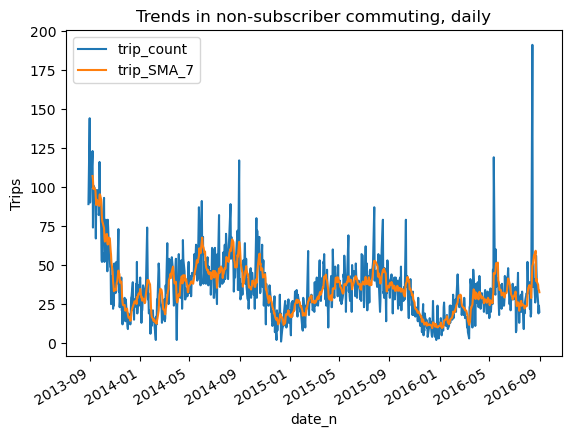

In [43]:
ax = time_df.plot()
ax.set_title('Trends in non-subscriber commuting, daily')
ax.set_ylabel('Trips')

### Trips by Start Station
We see Caltrain stations and those along major BART lines garnering the most non-subscriber rides. To capture these riders starting here, we should consider targeted offers based on this data.

---
**RECOMMENDATION**: Convert commuting non-subscribers by allowing riders to use their Clipper Card balance to pay for memberships. Since companies in the Bay Area often cover commuter expenses going to Clipper Card, this would allow for easier conversion since the customer is passing through the cost to their employer.

In [44]:
%%bigquery coord_start

SELECT 
distinct Station.latitude, 
Station.longitude, 
Station.name,
count(Trips.trip_id) as Total_trips
FROM `bigquery-public-data.san_francisco.bikeshare_stations` as Station 
JOIN `my-project-85244-313100.san_francisco_citi_bike_jw.bikeshare_commuter_trips` as Trips 
    ON Trips.start_station_id = Station.station_id
WHERE Trips.start_station_name IN 
    (SELECT start_station_name  
    FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
    WHERE subscriber_type = "Customer"  
    GROUP BY start_station_name 
    ORDER BY count(trip_id) desc limit 20)
GROUP BY
Station.latitude,
Station.longitude,
Station.name
ORDER BY Total_trips DESC

Downloading: 100%|██████████| 20/20 [00:01<00:00, 13.60rows/s]


In [45]:
coord_start.head()

latitude   longitude                                      name  \
0  37.776617 -122.395260  San Francisco Caltrain (Townsend at 4th)   
1  37.776600 -122.395470   San Francisco Caltrain 2 (330 Townsend)   
2  37.795392 -122.394203      Harry Bridges Plaza (Ferry Building)   
3  37.794139 -122.394434                         Steuart at Market   
4  37.780526 -122.390288                           2nd at Townsend   

   Total_trips  
0        43434  
1        33742  
2        22964  
3        21227  
4        20459

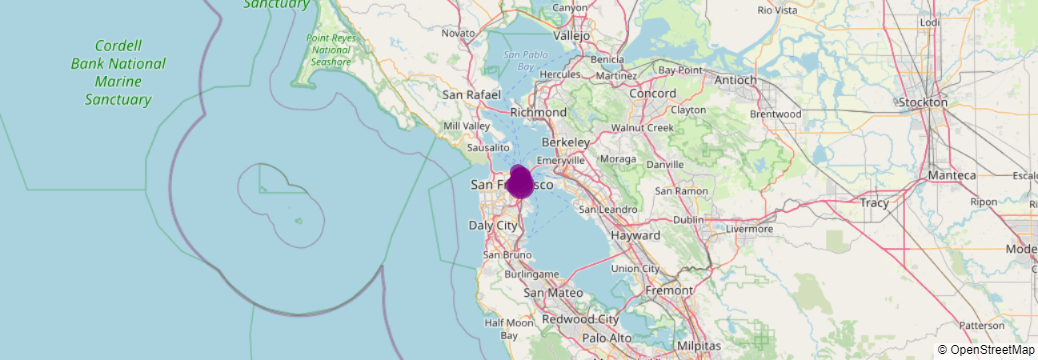

In [46]:
fig = px.scatter_mapbox(coord_start, lat="latitude", lon="longitude", hover_name="name", hover_data=["Total_trips"],
                        color_discrete_sequence=["purple"], height=300, size=coord_start['Total_trips']/100)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Dock Count
However, we can see that the most popular stations are not the stations with the most number of docks. This is a major problem. Given the consumer decision to use Bay Wheels as their method of commuter transportation will heavily rely on reliability/perceived reliability in having bikes available. 

---
**RECOMMENDATION**: Expand number of docks at key commuter stations.

In [47]:
%%bigquery dock_df

SELECT name,
dockcount
FROM `bigquery-public-data.san_francisco.bikeshare_stations`
ORDER BY dockcount DESC

Downloading: 100%|██████████| 74/74 [00:01<00:00, 49.87rows/s]


In [48]:
dock_df.head()

name  dockcount
0        Cyril Magnin St at Ellis St         35
1                5th St at Folsom St         31
2  San Jose Diridon Caltrain Station         27
3                    2nd at Townsend         27
4                     Market at 10th         27

In [49]:
%%bigquery commuter_docks_df

SELECT trips.start_station_name, 
count(*) as trip_count,
avg(stations.dockcount) as dock_count
FROM `my-project-85244-313100.san_francisco_citi_bike_jw.bikeshare_commuter_trips` as trips
JOIN `bigquery-public-data.san_francisco.bikeshare_stations` as stations
ON trips.start_station_id = stations.station_id
GROUP BY start_station_name
ORDER BY trip_count DESC

Downloading: 100%|██████████| 84/84 [00:01<00:00, 66.16rows/s]


In [50]:
commuter_docks_df.head()

start_station_name  trip_count  dock_count
0       San Francisco Caltrain (Townsend at 4th)       43434        19.0
1        San Francisco Caltrain 2 (330 Townsend)       33742        23.0
2  Temporary Transbay Terminal (Howard at Beale)       24219        23.0
3           Harry Bridges Plaza (Ferry Building)       22964        23.0
4                              Steuart at Market       21227        23.0

In [51]:
%%bigquery coord_dock

SELECT 
distinct latitude, 
longitude, 
name,
dockcount
FROM `bigquery-public-data.san_francisco.bikeshare_stations` as Station 
ORDER BY dockcount DESC

Downloading: 100%|██████████| 74/74 [00:01<00:00, 49.22rows/s]


In [52]:
coord_dock.head()

latitude   longitude                               name  dockcount
0  37.785908 -122.408891        Cyril Magnin St at Ellis St         35
1  37.780148 -122.403158                5th St at Folsom St         31
2  37.329732 -121.901782  San Jose Diridon Caltrain Station         27
3  37.780526 -122.390288                    2nd at Townsend         27
4  37.776619 -122.417385                     Market at 10th         27

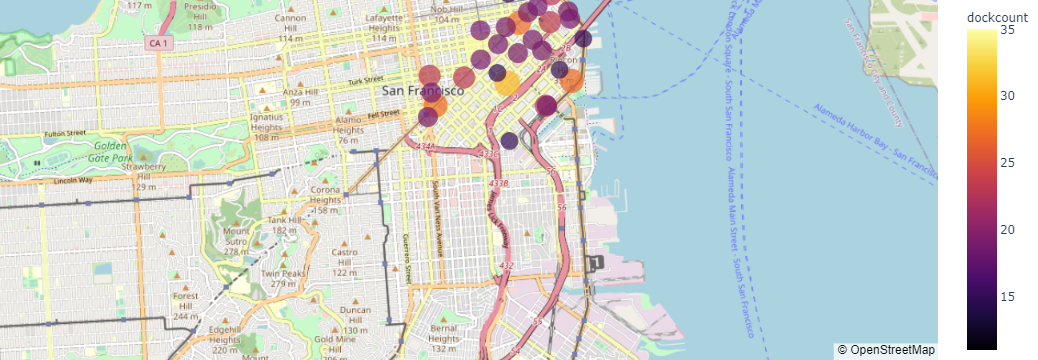

In [72]:
fig = px.scatter_mapbox(coord_dock, lat="latitude", lon="longitude", hover_name="name", hover_data=["dockcount"], color="dockcount",
                        color_continuous_scale='Inferno', height=300, size=coord_dock['dockcount']*1000)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Conclusion - Recommendations
---
1. Initiate promotions like free 30 day trial offers for commuters during periods of low ridership, Fall-Winter. 
2. Convert commuting non-subscribers by allowing riders to use their Clipper Card balance to pay for memberships.
3. Increase dock count at most popular start stations.
